# Testing GISSR-style inundation on ideal topo

Imports and setups

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h
from ideal_damage import Damage
from topo_ideal import Topo

In [3]:
topo_file = "Input/ideal_topo_gp_points_1_even.csv"
storm_file = "SurgeData/surge_w.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "SurgeData/time_w.csv"
damage_table_file = "Input/damage_table_combined.csv"

In [4]:
surge = pd.read_csv(storm_file).values
surge_time = pd.read_csv(time_file).values
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [5]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)


# Calculate indundation with varying sized walls
Equal height wall for all divs in divs_allocate

In [12]:
divs_allocate = [1]
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 2
h_num = 80

points = []
wall_height[positions] = h_start

for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[4,1]])
    print(height_div[4,1])

df = pd.DataFrame(points)
#df.to_csv("Output/single_section_varying_wall.csv")
#print(df)

2.217749218780181
1.6837108873642423
1.5690330134204562
1.4478063275490223
1.2920603759973601
1.1392677573639949
0.9875372476938005
0.8321221104023792
0.6726424803398099
0.5095864790608254
0.3504422785432321
0.218316516846164
0.11920318007637329
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Inundation with varying travel distance for redistribution

In [5]:
divs_allocate = list(range(18))

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 0
h_num = 1

points = []
wall_height[positions] = h_start

data = []
for r in range(18):
    params.travel_dist = r
    groups = generate_groups(Topo.div_data)

    for h in np.linspace(h_start, h_end, num=h_num):
        wall_height[:] = 0
        wall_height[positions] = h

        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)

        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
        
        #Damage
        dmg = Damage.calc_damage(height_grouped)
        cost_dmg = np.sum(dmg)
        cost_wall = np.sum(49212 * wall_height * segment_l)
        cost_tot = cost_dmg + cost_wall

        points.append([h, cost_wall, cost_dmg, cost_tot])

        data.append(height_grouped[2])
        #print(np.max(np.max(height_grouped, axis=1) - np.min(height_grouped, axis=1)))

df = pd.DataFrame(data)
df.to_csv("Output/ideal_test_travel.csv")

# PLOT


In [6]:
print(df)

          0         1         2         3         4         5         6   \
0   0.233891  0.263045  0.233891  0.270074  0.270074  0.270074  0.190971   
1   0.248895  0.243996  0.256149  0.258576  0.270074  0.246543  0.190971   
2   0.243996  0.250770  0.254748  0.261808  0.248996  0.225960  0.190971   
3   0.250770  0.254748  0.257366  0.248967  0.232744  0.210440  0.190971   
4   0.254748  0.257366  0.248967  0.232887  0.219568  0.205261  0.190971   
5   0.257366  0.248967  0.232887  0.219568  0.208301  0.202737  0.190077   
6   0.248967  0.232887  0.219568  0.208301  0.202737  0.194106  0.186491   
7   0.232887  0.219568  0.208301  0.202737  0.194106  0.186491  0.179708   
8   0.219568  0.208301  0.202737  0.194106  0.186491  0.179708  0.173614   
9   0.208301  0.202737  0.194106  0.186491  0.179708  0.173614  0.168101   
10  0.202737  0.194106  0.186491  0.179708  0.173614  0.168101  0.172666   
11  0.194106  0.186491  0.179708  0.173614  0.168101  0.172666  0.172384   
12  0.186491

We can see below that as the travel distance is increased the water level becomes more and more homogenous

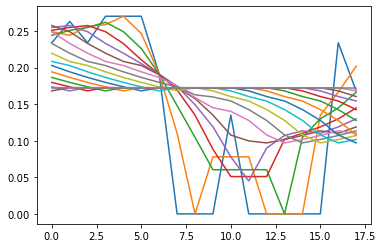

In [19]:
divs = list(range(18))
for div in divs:
    plt.plot(divs, data[div], label=div)
#plt.legend()

Plot height as function of volume

<IPython.core.display.Javascript object>


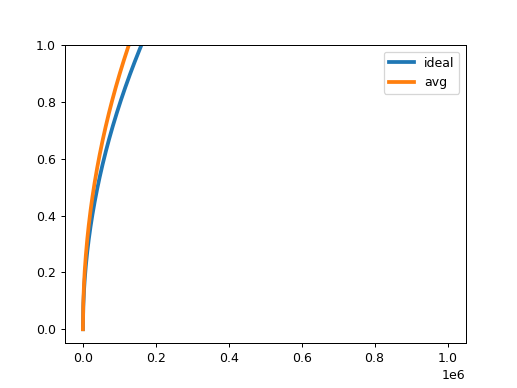

(-0.05, 1.0)

In [26]:
%matplotlib notebook
surge_peak = 5
vol = np.linspace(0, 10**6, 1000)
h = np.minimum(np.sqrt((2 * vol * 0.0025) / 800), surge_peak)
plt.plot(vol, h, label='ideal', linewidth=3)
plt.ylim(-0.05, 1)

<IPython.core.display.Javascript object>


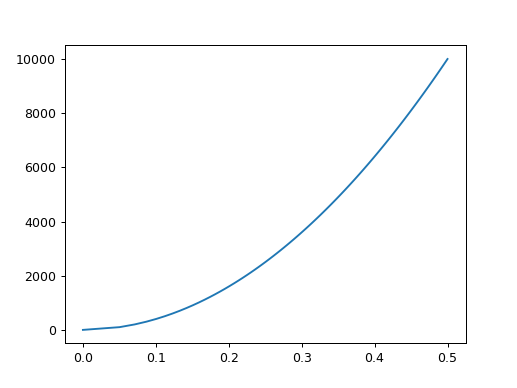

In [10]:
surge_peak = 3
vol = np.linspace(0, 10000, 100)
h = np.minimum(np.sqrt((2 * vol * 0.01) / 800), surge_peak)
plt.plot(h, vol)

# Fit surface volume to all data, for testing purpoes
Since the ideal topo does not have buildings the surface volume func is very unrealistic, try fitting a bunch of data to get an approximation

In [28]:
import glob
from scipy.optimize import curve_fit

def func_fit(vol, a, b):
    return a*np.sqrt(vol) + b*vol

files = glob.glob(r"../NewSurfaceVolumeCombined/LMN_div18_*.csv")
H = np.append(np.linspace(0, 3, 13), np.linspace(3.5, 7, 8))
points = np.zeros((H.size * 18, 2))

for i, f in enumerate(files):
    surfaceV_h = pd.read_csv(f)
    points[H.size*i:H.size*(i+1), :] = surfaceV_h.to_numpy()


coeff, cov = curve_fit(func_fit, points[:,1], points[:, 0])
df = pd.DataFrame(coeff, index=["a", "b"])
df.to_csv("surfaceV_coeff.csv")

In [29]:
vol = np.linspace(0, 10**6, 1000)
h = func_fit(vol, coeff[0], coeff[1])
plt.plot(vol, h, label='avg', linewidth=3)
plt.legend()

# Fit surface volume to each div for reference

In [13]:
for div in range(18):
    coeff, cov = curve_fit(func_fit, points[div*H.size:(div+1)*H.size, 1], points[div*H.size:(div+1)*H.size, 0])
    vol = np.linspace(0, 10**6, 1000)
    h = func_fit(vol, coeff[0], coeff[1])
    plt.plot(vol, h)
    

# Plot Cwr as function of surge and h_crit

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


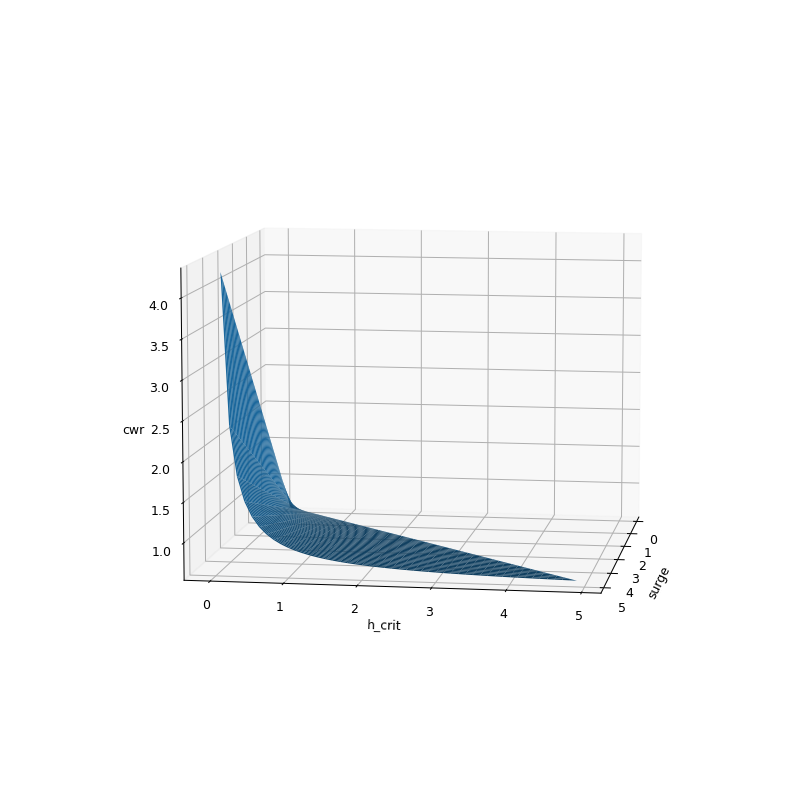

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


Text(0.5, 0, 'cwr')

In [36]:
%matplotlib notebook
def cwr(surge, h_crit):
    return 0.611 + 0.075 * (surge-h_crit) / h_crit
surge = np.linspace(0, 5, 50)
h_crit = np.linspace(5, 0.1, 50)
surge, h_crit = np.meshgrid(surge, h_crit)
surge, h_crit = np.where(surge > h_crit, surge, 0), np.where(surge > h_crit, h_crit, 0)
c = cwr(surge, h_crit)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(surge, h_crit, c)

fig.set_size_inches(10, 10)
ax.set_xlabel('surge')
ax.set_ylabel('h_crit')
ax.set_zlabel('cwr')

# Points below line are Cwr>1

<IPython.core.display.Javascript object>


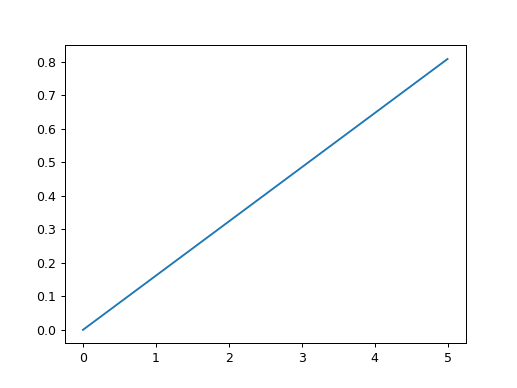

In [12]:
plt.figure(2)
surge = np.linspace(0, 5, 100)
h_crit = surge / (1+0.389/0.075)
plt.plot(surge, h_crit)

# Volume in division as function of surge and critical elev

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  


<IPython.core.display.Javascript object>


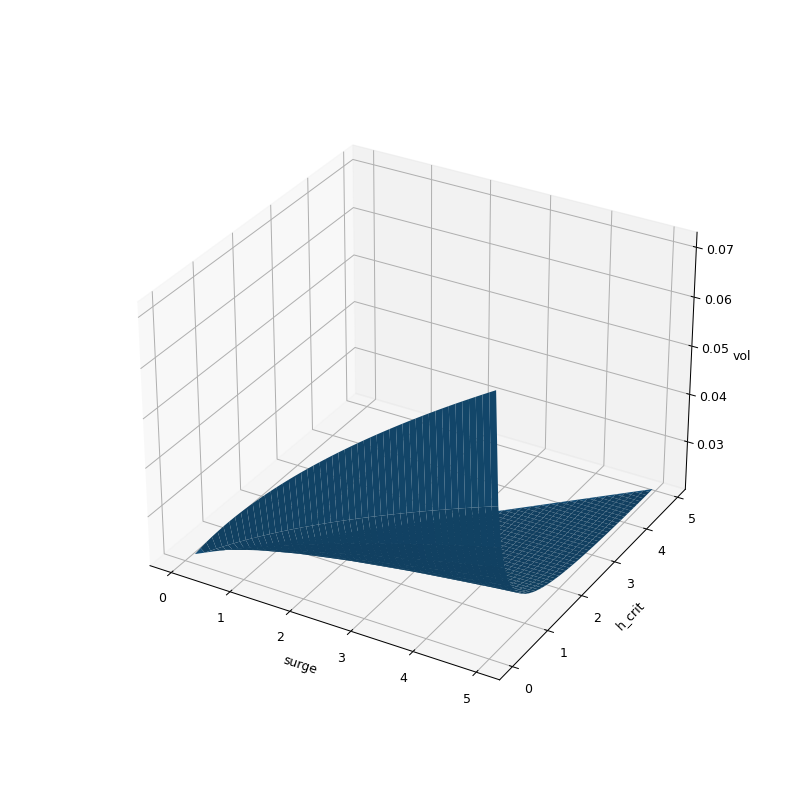

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


Text(0.5, 0, 'vol')

In [31]:
def vol_func(h_s, h_c):
    l = 100
    dt = 1
    dh = h_s-h_c
    S = 0.01
    R = 0.16
    cwr = 0.611 + 0.075 * dh / h_c
    vol = (l * dt * dh * cwr * (l * dh *(l + 2 * dh)) ** (-1)) ** (2/3) * S ** (1/2) / R
    return vol

surge = np.linspace(0, 5, 50)
h_crit = np.linspace(5, 0.1, 50)
surge, h_crit = np.meshgrid(surge, h_crit)
surge, h_crit = np.where(surge > h_crit, surge, 0), np.where(surge > h_crit, h_crit, 0)
vol = vol_func(surge, h_crit)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(surge, h_crit, vol)

fig.set_size_inches(10, 10)
ax.set_xlabel('surge')
ax.set_ylabel('h_crit')
ax.set_zlabel('vol')

# Plot Tide

<IPython.core.display.Javascript object>


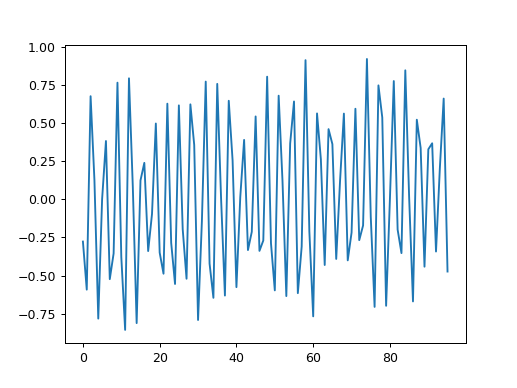

In [36]:
class Tide:
    def __init__(self, const_file="Input/tidal_constituents.csv"):
        constituents = pd.read_csv(const_file)
        self.amplitudes =  constituents["Amplitude"].to_numpy()
        self.phases = constituents["Phase"].to_numpy()
        self.speeds = constituents["Speed"].to_numpy()

    def get_tide_height(self, t):
        return np.sum(self.amplitudes * np.cos(t * self.speeds + self.phases))

tide = Tide()
h = []
for t in range(96):
    h.append(tide.get_tide_height(t))

plt.figure()
plt.plot(list(range(96)), h)